In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from ucimlrepo import fetch_ucirepo 
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 
# metadata 
print(wine_quality.metadata) 
# variable information 
print(wine_quality.variables) 


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [3]:
X.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


(array([  30.,  216.,    0., 2138.,    0., 2836., 1079.,    0.,  193.,
           5.]),
 array([3. , 3.6, 4.2, 4.8, 5.4, 6. , 6.6, 7.2, 7.8, 8.4, 9. ]),
 <BarContainer object of 10 artists>)

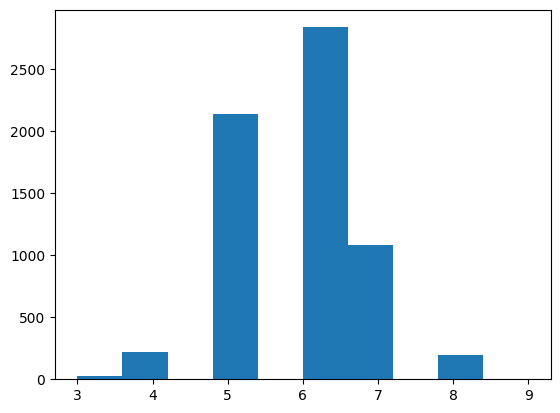

In [4]:
plt.hist(y)


In [5]:
# Splitting dataset
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating binary target variable
train_y["target"] = (train_y["quality"] > 5).astype(int)
test_y["target"] = (test_y["quality"] > 5).astype(int)

# Dropping the original 'quality' column
train_y.drop(columns=["quality"], inplace=True)
test_y.drop(columns=["quality"], inplace=True)

# Convert to PyTorch tensors
train_x = torch.tensor(train_x.values, dtype=torch.float32)
test_x = torch.tensor(test_x.values, dtype=torch.float32)
train_y = torch.tensor(train_y.values, dtype=torch.long).squeeze()  # Remove extra dimension
test_y = torch.tensor(test_y.values, dtype=torch.long).squeeze()    # Remove extra dimension

# Creating TensorDataset
train = TensorDataset(train_x, train_y)
test = TensorDataset(test_x, test_y)

# Check shapes
print(f"Train X Shape: {train_x.shape}, Train Y Shape: {train_y.shape}")
print(f"Test X Shape: {test_x.shape}, Test Y Shape: {test_y.shape}")

Train X Shape: torch.Size([5197, 11]), Train Y Shape: torch.Size([5197])
Test X Shape: torch.Size([1300, 11]), Test Y Shape: torch.Size([1300])


In [6]:
train_y.shape

torch.Size([5197])

In [ ]:

class ANN_Model(nn.Module):  # Fixed parent class
    def __init__(self, batch_size, learning_rate, epochs, train_data, test_data):
        super().__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs

        # Define layers
        self.fc1 = nn.Linear(11, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)  # Fixed last layer

        self.train_data = train_data
        self.test_data = test_data

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # Fixed last layer
        return x

    def train_model(self):
        train_loader = DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(self.test_data, batch_size=len(self.test_data.tensors[0]))

        loss_function = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)

        for epoch in range(self.epochs):
            self.train()  # Set to training mode
            total_train_loss = 0

            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = self.forward(X_batch).squeeze()  # Forward pass
                loss = loss_function(outputs, y_batch.float())  # Compute loss
                loss.backward()  # Backpropagation
                optimizer.step()  # Update weights

                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)

            # Evaluation on test data
            self.eval()  # Set to evaluation mode
            total_test_loss = 0
            correct = 0
            total = 0

            with torch.no_grad(): #disable gradient computation during evaluation to save mermory and save up the computation
                for X_test, y_test in test_loader:
                    test_outputs = self.forward(X_test).squeeze()
                    test_loss = loss_function(test_outputs, y_test.float())
                    total_test_loss += test_loss.item()

                    # Convert logits to probabilities
                    predicted = torch.sigmoid(test_outputs).round()
                    correct += (predicted == y_test).sum().item()
                    total += y_test.size(0)

            avg_test_loss = total_test_loss / len(test_loader)
            accuracy = correct / total * 100

            print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {avg_train_loss:.4f}, "
                  f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")


In [9]:

model = ANN_Model(batch_size=16, learning_rate=0.01, epochs=1000, train_data=train, test_data=test)
model.train_model()

Epoch 1/1000, Train Loss: 0.6694, Test Loss: 0.6486, Test Accuracy: 65.69%
Epoch 2/1000, Train Loss: 0.6579, Test Loss: 0.6438, Test Accuracy: 64.38%
Epoch 3/1000, Train Loss: 0.6516, Test Loss: 0.6379, Test Accuracy: 64.77%
Epoch 4/1000, Train Loss: 0.6487, Test Loss: 0.6743, Test Accuracy: 60.46%
Epoch 5/1000, Train Loss: 0.6452, Test Loss: 0.6300, Test Accuracy: 65.77%
Epoch 6/1000, Train Loss: 0.6440, Test Loss: 0.6291, Test Accuracy: 65.69%
Epoch 7/1000, Train Loss: 0.6432, Test Loss: 0.6279, Test Accuracy: 64.77%
Epoch 8/1000, Train Loss: 0.6388, Test Loss: 0.6347, Test Accuracy: 63.38%
Epoch 9/1000, Train Loss: 0.6383, Test Loss: 0.6355, Test Accuracy: 63.15%
Epoch 10/1000, Train Loss: 0.6388, Test Loss: 0.6270, Test Accuracy: 65.23%
Epoch 11/1000, Train Loss: 0.6343, Test Loss: 0.6578, Test Accuracy: 60.62%
Epoch 12/1000, Train Loss: 0.6326, Test Loss: 0.6129, Test Accuracy: 64.92%
Epoch 13/1000, Train Loss: 0.6297, Test Loss: 0.6129, Test Accuracy: 65.15%
Epoch 14/1000, Train 